# 0. Environment Setup and Configuration

## 0.1 Library Installation and Upgrade

In [ ]:
# Install the necessary libraries for data manipulation, transformers,
# and training utilities.
!pip install transformers datasets accelerate -U
!pip install evaluate scikit-learn numpy pandas torch
!pip install transformers[torch]
!pip install emoji

## 0.2 Google Drive Access and Data Path Configuration

This block is required to mount Google Drive in Colab, allowing access to data files and persistence of model checkpoints/results.

In [ ]:
from google.colab import drive

# Start the authorization process to mount the Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

BASE_DATA_PATH = '/content/drive/MyDrive/MultiPRIDE_Project/'
print(f"Input data path set to: {BASE_DATA_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Input data path set to: /content/drive/MyDrive/MultiPRIDE_Project/


## 0.3 Imports and Reproducibility Settings

In [ ]:
# Imports
import os
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import re
import html
import emoji

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset

from IPython.display import display
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Hugging Face Imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    XLMRobertaConfig,
    EarlyStoppingCallback,
    XLMRobertaForSequenceClassification
)

# We need the base class for the custom model
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.trainer import Trainer

# Global Configuration
GLOBAL_SEED = 42 # For reproducibility
NUM_LABELS = 2

# Device configuration
# Define the computing device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

# Reproducibility function
def set_seed(seed):
    # Sets the seed across all relevant libraries for reproducibility
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Settings for GPU stability
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Execute the function with the global seed value
set_seed(GLOBAL_SEED)
print(f"Seed fixed to {GLOBAL_SEED} for reproducibility.")

Device in use: cuda
Seed fixed to 42 for reproducibility.


# 1. Data Loading and Integration

## 1.1 Loading and Error Handling

In [ ]:
# Data Loading
try:
    # Load Training Files (IT, ES, EN)
    df_it_train = pd.read_csv('train_it.csv')
    df_es_train = pd.read_csv('train_es.csv')
    df_en_train = pd.read_csv('train_en.csv')

    # Load Test Files (IT, ES, EN)
    df_it_test = pd.read_csv('it_test.csv')
    df_es_test = pd.read_csv('es_test.csv')
    df_en_test = pd.read_csv('en_test.csv')

except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    # Terminate execution if files are not found
    raise

## 1.2 Merging and Renaming Training Data

In [ ]:
# Merge Training Data
df_combined_train = pd.concat([df_it_train, df_es_train, df_en_train], ignore_index=True)
print(f"Total Combined Training Pool Size: {len(df_combined_train)} samples.")
# Ensure 'label' column is consistent for training purposes
df_combined_train = df_combined_train.rename(columns={'target_label': 'label'}, errors='ignore')

Total Combined Training Pool Size: 2988 samples.


## 1.3 Merging Test Data

In [ ]:
# Merge Test Data
df_combined_test = pd.concat([df_it_test, df_es_test, df_en_test], ignore_index=True)
print(f"Total Combined Test Pool Size: {len(df_combined_test)} samples.")

Total Combined Test Pool Size: 1995 samples.


# 2. Data Inspection and Initial Data Quality Check

## 2.1 Display Data and Basic Statistics

In [ ]:
# 1. Display Training Data
print("\n--- Training Data: df_combined_train (First 5 Rows) ---")
# Use the display function for a formatted table output
display(df_combined_train.head())

print(f"\nTraining Data Shape: {df_combined_train.shape}")
print("Training Data Label Distribution:")
print(df_combined_train['label'].value_counts())

# 2. Display Test Data
print("\n--- Official Test Data: df_combined_test (First 5 Rows) ---")
# Use the display function for a formatted table output
display(df_combined_test.head())

print(f"\nTest Data Shape: {df_combined_test.shape}")


--- Training Data: df_combined_train (First 5 Rows) ---


,id,text,bio,label,lang
0,it_1231,La destra Italiana pur di non dire che loro od...,Il rispetto per il prossimo qualunque sia il s...,0,it
1,it_1713,"""Presupporre che tutti i bisessuali non sono m...",𝓕𝓲𝓵𝓵𝓮𝓭 𝔀𝓲𝓽𝓱 𝓯𝓾𝓻𝔂 𝓪𝓷𝓭 𝓼𝓽𝓪𝓻𝓻𝔂 𝓮𝔂𝓮𝓭,0,it
2,it_1474,"Se i diritti devono essere uguali, voglio che ...",User Experience Designer URL,0,it
3,it_58,che poi molti uomini trans subiscono lesbofobi...,"no matter where i go, you're there …",0,it
4,it_511,Che poi è l’etero medio come Pio e Amedeo che ...,T'appartengo ed io ci tengo \nE se prometto po...,0,it



Training Data Shape: (2988, 5)
Training Data Label Distribution:
label
0    2560
1     428
Name: count, dtype: int64

--- Official Test Data: df_combined_test (First 5 Rows) ---


,id,text,bio,lang
0,it_406,@USER @USER Oggi avrò di che parlare coi colle...,NaN,it
1,it_138,@USER Il problema è che c’è tantissima omofobi...,"Slave, passive, submissive. Available for Mast...",it
2,it_1622,dua lipa bella hadid kendall jenner hunter sch...,˗ˏˋyou bring me homeˊ˗ she / her ›››››,it
3,it_1401,"🏳️‍🌈🏳️‍🌈🏳️‍🌈\nFatelo per lui, per tutte le vit...",Cit - Allora scusate ma se io mi metto una bot...,it
4,it_807,"No Pride fisico, ma potete sempre dare uno sgu...","Mi piace disegnare, mi piacciono i videogiochi...",it



Test Data Shape: (1995, 4)


The distribution of the target variable shows a pronounced **class imbalance**.

The reclaimed language (Label 1) represents only about 14.3% of the total samples.

This imbalance confirms that Accuracy will be a misleading metric. This output justifies the necessary use of the *Macro F1* Score as the primary evaluation metric, as it equally weights the performance of both classes.

## 2.2 Missing Data Analysis

In [ ]:
# 1. Missing Data Analysis
print("\n--- Missing Data Analysis ---")

# Function to analyze missing data by language
def analyze_missing_by_language(df, df_name):
    # Identify columns in the DataFrame that contain any missing values
    missing_cols = df.columns[df.isnull().any()].tolist()

    if not missing_cols:
        print(f"\n[{df_name}] No missing values found in any column.")
        return

    print(f"\n[{df_name}] Percentage of Missing Values per Column, Broken Down by Language:")

    # Group by language and calculate the percentage of missing values for the relevant columns
    missing_by_lang = df.groupby('lang')[missing_cols].apply(
        lambda x: x.isnull().sum() / len(x) * 100
    )

    # Filter out languages where all of the identified columns are 0% missing
    missing_by_lang = missing_by_lang[~(missing_by_lang == 0).all(axis=1)]

    # Rename columns for clarity
    missing_by_lang.columns = [f'% Missing {col}' for col in missing_cols]

    if not missing_by_lang.empty:
        display(missing_by_lang)
    else:
        print("Missing data is not localized by language group or the overall missing data is negligible.")

    # Overall Missing Percentage
    print(f"\n[{df_name}] Overall Missing Percentage (Across All Languages):")
    overall_missing = df[missing_cols].isnull().sum() / len(df) * 100
    display(overall_missing.to_frame(name='Overall % Missing'))

# 1.1 Training Data Missing Values
analyze_missing_by_language(df_combined_train, "TRAINING DATA")

# 1.2 Test Data Missing Values
analyze_missing_by_language(df_combined_test, "TEST DATA")


--- Missing Data Analysis ---

[TRAINING DATA] Percentage of Missing Values per Column, Broken Down by Language:


,% Missing bio
lang,
en,100.000000
es,5.593607
it,7.918969



[TRAINING DATA] Overall Missing Percentage (Across All Languages):


,Overall % Missing
bio,38.855422



[TEST DATA] Percentage of Missing Values per Column, Broken Down by Language:


,% Missing bio
lang,
en,100.000000
es,5.982906
it,7.586207



[TEST DATA] Overall Missing Percentage (Across All Languages):


,Overall % Missing
bio,38.847118


The analysis clearly shows that missing values are confined exclusively to the *bio* column.

1. **Structural Absence**: The English (en) subset is confirmed to have 100% missing *bio* values in both Training and Test sets, indicating the column was structurally absent in the original 'en' files.

2. **Random NaN**: Spanish (es) and Italian (it) subsets show a minor, random percentage (5-8%) of NaNs, meaning the bio field was simply empty for those specific users.




## 2.3 Missing Data Handling

Since *bio* is required for Task B, we replace all observed NaNs with an empty string ("") to ensure robust and consistent feature extraction.

In [ ]:
# 2. Specific NaN Handling for 'bio' Column
print("\n--- Executing NaN Handling for 'bio' Column ---")

# 2.1 Clean Training Data
# Fill all NaN values in the 'bio' column of the combined training data with an empty string ("").
df_combined_train['bio'] = df_combined_train['bio'].fillna("")
print(f"Training NaN count in 'bio' column after cleaning: {df_combined_train['bio'].isna().sum()}")

# 2.2 Clean Test Data
df_combined_test['bio'] = df_combined_test['bio'].fillna("")
print(f"Test NaN count in 'bio' column after cleaning: {df_combined_test['bio'].isna().sum()}")

print("\nCleanup complete. All 'bio' NaN values replaced with empty strings for multimodal processing.")


--- Executing NaN Handling for 'bio' Column ---
Training NaN count in 'bio' column after cleaning: 0
Test NaN count in 'bio' column after cleaning: 0

Cleanup complete. All 'bio' NaN values replaced with empty strings for multimodal processing.


# 3. Text Preprocessing and Cleaning

## 3.1 Definition of the Cleaning Function

In [ ]:
# Define the Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Emoji normalization: Convert emojis to their text description
    # This preserves semantic context for the model.
    # We use delimiters to ensure the text description is treated as a separate token.
    text = emoji.demojize(text, delimiters=(" ", " "))

    # 2. Lowercasing: Ensures text consistency, though XLM-R is generally robust to casing.
    text = text.lower()

    # 3. Replace URLs: Uniformly replace all URLs with a single, padded token ' URL '
    # This reduces noise and prevents the model from overfitting to random URL strings.
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+|t\.co/\S+', ' URL ', text)

    # 4. Replace Mentions: Uniformly replace all @mentions with a single, padded token '@USER'
    # The identity of the user mentioned is irrelevant to the classification task.
    text = re.sub(r'@\w+', ' @USER ', text)

    # 5. Decode HTML Entities: Convert codes like &amp; to their actual characters (&)
    text = html.unescape(text)

    # 6. Clean up extra whitespace and newlines/tabs
    # Remove any stray newlines or tabs
    text = text.replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    # Consolidate multiple spaces into single spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

## 3.2 Application of Cleaning

In [ ]:
# 1. Apply cleaning to Training Data
print("Applying cleaning to Training Data ('text' and 'bio')...")
df_combined_train['text'] = df_combined_train['text'].apply(clean_text)
df_combined_train['bio'] = df_combined_train['bio'].apply(clean_text)
print("Training Data successfully cleaned.")

# 2. Apply cleaning to Test Data
print("\nApplying cleaning to Test Data ('text' and 'bio')...")
df_combined_test['text'] = df_combined_test['text'].apply(clean_text)
df_combined_test['bio'] = df_combined_test['bio'].apply(clean_text)
print("Test Data successfully cleaned.")

Applying cleaning to Training Data ('text' and 'bio')...
Training Data successfully cleaned.

Applying cleaning to Test Data ('text' and 'bio')...
Test Data successfully cleaned.


# 4. Exploratory Data Analysis (EDA)

## 4.1 Language and Label Distribution Analysis


--- 1. Language Distribution (Task A) ---


,count
lang,
it,1086
en,1026
es,876


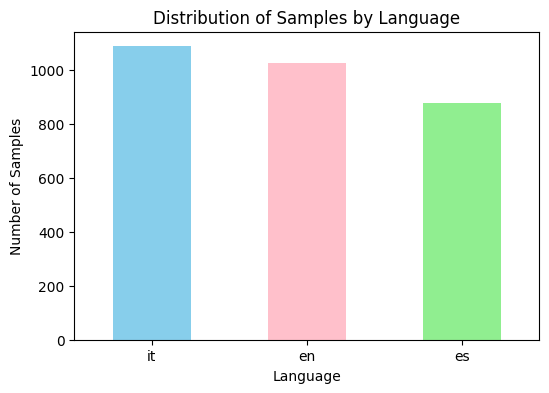

In [ ]:
# 1. Analyze Language Distribution
lang_counts = df_combined_train['lang'].value_counts()
print("\n--- 1. Language Distribution (Task A) ---")
display(lang_counts.to_frame())

# Plot Language Distribution
plt.figure(figsize=(6, 4))
lang_counts.plot(kind='bar', color=['skyblue', 'pink', 'lightgreen'])
plt.title('Distribution of Samples by Language')
plt.xlabel('Language')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

The data is relatively **well-balanced across the three languages**. This distribution justifies the choice of a multilingual Transformer model. Since no single language heavily dominates the others, the model is expected to learn useful representations for all three languages without being significantly biased towards any particular one.


--- 2. Label Distribution (Data Imbalance) ---


,count
label,
0,2560
1,428


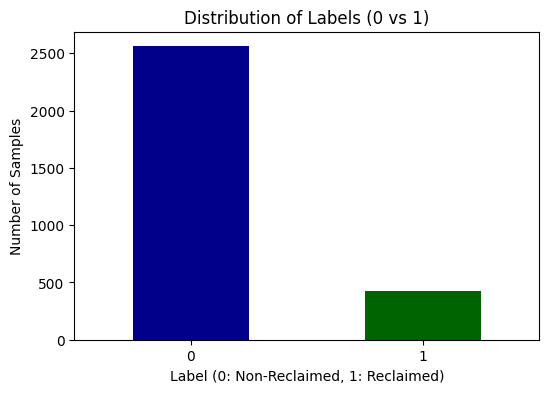

In [ ]:
# 2. Analyze Label Distribution (Data Imbalance Check)
label_counts = df_combined_train['label'].value_counts().sort_index()
print("\n--- 2. Label Distribution (Data Imbalance) ---")
# 0: Non-Reclaimed/Denigratory, 1: Reclaimed Language
display(label_counts.to_frame())

# Plot Label Distribution
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['darkblue', 'darkgreen'])
plt.title('Distribution of Labels (0 vs 1)')
plt.xlabel('Label (0: Non-Reclaimed, 1: Reclaimed)')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

The **analysis of the label distribution** reveals a severe **class imbalance** within the training set. This imbalance is the primary driver for key decisions in the modeling setup:

  1. Loss Function: It necessitates the use of **Weighted Cross-Entropy Loss**, which assigns higher penalty weights to misclassifications of the minority class.

  2. Evaluation Metric: It confirms that the evaluation must rely on metrics that are robust to imbalance, such as the **Macro F1 Score**, which treats the F1 Score of both classes equally.

## 4.2 Text Lenght and Word Cloud Analysis


--- 3. Text Length Analysis ---
Average token length (words): 35.60
Maximum token length (words): 148


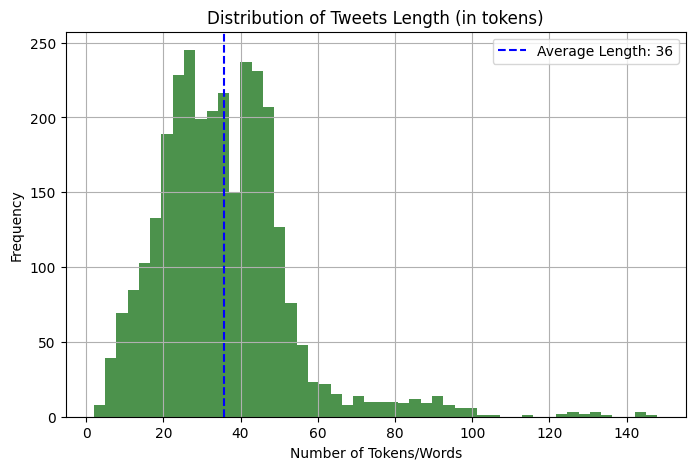

In [ ]:
# 3. Analyze Text Length Distribution
# We calculate length based on words/tokens (space-separated)
df_combined_train['text_length'] = df_combined_train['text'].apply(lambda x: len(str(x).split()))
avg_length = df_combined_train['text_length'].mean()
max_length = df_combined_train['text_length'].max()

print(f"\n--- 3. Text Length Analysis ---")
print(f"Average token length (words): {avg_length:.2f}")
print(f"Maximum token length (words): {max_length}")

# Plot Text Length Distribution (validates MAX_LENGTH = 128)
plt.figure(figsize=(8, 5))
df_combined_train['text_length'].hist(bins=50, color='darkgreen', alpha=0.7)
plt.title('Distribution of Tweets Length (in tokens)')
plt.xlabel('Number of Tokens/Words')
plt.ylabel('Frequency')
plt.axvline(x=avg_length, color='blue', linestyle='--', label=f'Average Length: {avg_length:.0f}')
plt.legend()
plt.show()

The analysis of tweets length is crucial for setting the **MAX_LENGTH** hyperparameter, which directly impacts model memory usage and potential data loss through truncation.

The **average message length** is **35.60** tokens, confirming that the dataset primarily consists of relatively short texts. The **maximum length** observed is **148** tokens.

The histogram clearly shows a heavily right-skewed distribution, with the vast majority of tweets clustered between 20 and 60 tokens, centering around the average of 36 tokens.

This initial analysis suggests that a **MAX\_LENGTH** value that is a power of two, such as 128 tokens, would be highly efficient, minimizing padding and GPU memory usage while capturing virtually all relevant data and only truncating a small number of extreme outliers.




--- 5. Word Cloud for Non-Reclaimed Language (Label 0) ---


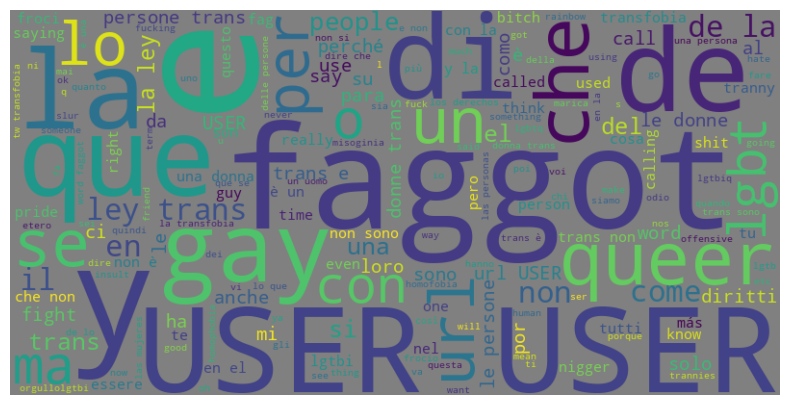

In [ ]:
# 4. Generate Word Clouds for Majority Class
# Combine text for Non-Reclaimed/Denigratory Language (Label 0)
text_label_0 = " ".join(df_combined_train[df_combined_train['label'] == 0]['text'].tolist())

print("\n--- 5. Word Cloud for Non-Reclaimed Language (Label 0) ---")
wordcloud_0 = WordCloud(width=800, height=400, background_color='grey').generate(text_label_0)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.show()

The Word Cloud for Label 0 clearly highlights denigratory terms alongside non-informative tokens such as "user" and implicit URLs (represented by standard tokens after cleaning).

We will not remove the high-frequency "noise" tokens like "user" and "url" for two strategic reasons:

  1.  **Transformer Capability**: Advanced Transformer models like XLM-RoBERTa are inherently designed to assign low importance (low attention weights) to frequent but contextually irrelevant tokens. The model learns to ignore the noise automatically.

  2. **Context Preservation**: Removing a token like "url" or "user" might unintentionally break the sequence flow or mask a subtle pattern that the model could potentially use for context, especially in short social media texts. Keeping the tokens allows the model to leverage all available information.



--- 4. Word Cloud for Reclaimed Language (Label 1) ---


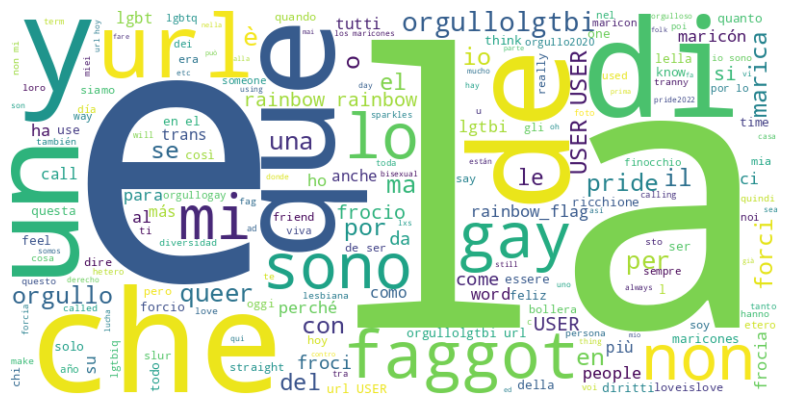

In [ ]:
# 5. Generate Word Clouds for Minority Class
# Combine text for Reclaimed Language (Label 1) to identify key terms
text_label_1 = " ".join(df_combined_train[df_combined_train['label'] == 1]['text'].tolist())

print("\n--- 4. Word Cloud for Reclaimed Language (Label 1) ---")
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_label_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

The Word Cloud for Label 1 confirms the core challenge of the task:

-  **Context is Key**: The most frequent terms include slurs alongside identity markers and pride concepts ("orgullo," "pride," "rainbow"). This proves that reclamation relies on contextual intent, not just word presence.



# 5. Dataset, Tokenization, and Input Preparation

## 5.1 Tokenization Configuration

In [ ]:
# Define the base multilingual model
MODEL_NAME = 'xlm-roberta-base'
MAX_LENGTH = 128

print(f"\n--- Configuring Tokenizer ({MODEL_NAME}) ---")

# Load the XLM-RoBERTa Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


--- Configuring Tokenizer (xlm-roberta-base) ---


## 5.2 Custom Dataset Helper Functions and Classes

### 5.2.1 Text-Only Dataset (Task A)

In [ ]:
# Helper function to tokenize a single row. This function performs the actual tokenization logic.
def tokenize_text_only(row, tokenizer, max_length):
    # Tokenize the 'text' column, truncating or padding to MAX_LENGTH
    encoding = tokenizer(
        row['text'],
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

    # Add label to the result dictionary, handling the case where labels are missing (Test Set)
    if 'label' in row.index:
        encoding['labels'] = row['label']
    else:
        # Use -100 for the test set; standard HF convention to ignore the loss.
        encoding['labels'] = -100

    return encoding

# --- Custom Dataset Class for Task A (Text-Only) ---
# Inputs: Only the main text column
class TextOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.encoded_data = self.df.apply(
            lambda row: tokenize_text_only(row, tokenizer, max_length), axis=1
        ).tolist()

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        item = self.encoded_data[idx]

        # Convert the pre-tokenized lists/values into PyTorch tensors for the Trainer.
        # The data type must match the expected input types (long for IDs/masks/labels).
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(item['labels'], dtype=torch.long)
        }

### 5.2.2 Multimodal Dataset (Task B)

In [ ]:
# Define the number of numerical features we are injecting (here, just the length of the bio)
NUM_BIO_FEATURES = 1

# Helper function for Multimodal Tokenization and Feature Extraction
def tokenize_multimodal(row, tokenizer, max_length):
    text = str(row['text'])
    bio = str(row['bio'])

    # 1. Tokenization: Combine text and bio as two sequences (Input 1 and Input 2)
    encoding = tokenizer(
        text,
        bio, # The second sequence (bio)
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

    # 2. Extract and Normalize Numerical Feature (Length of bio)
    bio_feature_vector = [len(bio) / 100.0]

    # Add numerical features to the encoding dictionary
    encoding['bio_features'] = bio_feature_vector

    # 3. Add label
    if 'label' in row.index:
        encoding['labels'] = row['label']
    else:
        encoding['labels'] = -100

    return encoding

# --- Custom Dataset Class for Task B (Multimodal: Text + Bio) ---
# Inputs: Combines 'text' and 'bio' columns
class MultiPRIDEDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Apply the helper function to every row and store the results
        self.encoded_data = df.apply(
             lambda row: tokenize_multimodal(row, tokenizer, max_length), axis=1
        ).tolist()

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        item = self.encoded_data[idx]

        # Convert pre-computed lists/values into PyTorch tensors
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long),
            # Crucial: Numerical features must be float32
            'bio_features': torch.tensor(item['bio_features'], dtype=torch.float32),
            'labels': torch.tensor(item['labels'], dtype=torch.long)
        }

## 5.3 Data Split (Stratified) and Class Weight Calculation

Split the combined dataset into **Training** (80%) and **Validation** (20%) sets.

Stratification is crucial to maintain the label distribution in both sets, which is important due to the class imbalance.

In [ ]:
# 1. Perform Stratified Split
df_train, df_val = train_test_split(
    df_combined_train,
    test_size=0.2, # 80% Train, 20% Validation
    stratify=df_combined_train['label'],
    random_state=GLOBAL_SEED
)

print(f"\nTraining Set Size: {len(df_train)}")
print(f"Validation Set Size: {len(df_val)}")

# 2. Validation of Stratification
print("\nValidation Subset Label Distribution Check:")
# Check the distribution percentage in the validation set
val_dist = df_val['label'].value_counts(normalize=True).sort_index() * 100
print("Percentage distribution in Validation Set:")
display(val_dist.to_frame(name='Val %'))

print("\nTraining Subset Label Distribution Check:")
# Check the distribution percentage in the training set
train_dist = df_train['label'].value_counts(normalize=True).sort_index() * 100
print("Percentage distribution in Training Set:")
display(train_dist.to_frame(name='Train %'))

print("\nData splitting complete. Both training and validation sets maintain the original label proportions.")


Training Set Size: 2390
Validation Set Size: 598

Validation Subset Label Distribution Check:
Percentage distribution in Validation Set:


,Val %
label,
0,85.618729
1,14.381271



Training Subset Label Distribution Check:
Percentage distribution in Training Set:


,Train %
label,
0,85.690377
1,14.309623



Data splitting complete. Both training and validation sets maintain the original label proportions.


In [ ]:
# 1. Calculate weights based on the class distribution of the full training set (IT+ES+EN).
# These weights will be used in the custom loss function to prioritize the minority class (Label 1).
label_counts = df_train['label'].value_counts().sort_index()
total_samples = len(df_train)
num_classes = len(label_counts)

# 2. Calculate balanced class weights: weight_i = total_samples / (num_classes * count_i)
# This assigns lower weights to the majority class (Label 0) and higher weights to the minority class (Label 1).
class_weights = total_samples / (num_classes * label_counts)

# 3. Convert weights to a PyTorch Tensor
weights_tensor = torch.tensor(class_weights.to_numpy(), dtype=torch.float32)

# 4. Determine device and move weights to the GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CLASS_WEIGHTS will be used in the custom loss function
CLASS_WEIGHTS = weights_tensor.to(device)

print("--- Class Weights Summary (Full Training Set) ---")
print(f"Class Distribution:\n{label_counts.to_markdown()}")
print(f"Calculated Class Weights (Label 0, Label 1): {CLASS_WEIGHTS.tolist()}")
print(f"Device in use: {device}")

--- Class Weights Summary (Full Training Set) ---
Class Distribution:
|   label |   count |
|--------:|--------:|
|       0 |    2048 |
|       1 |     342 |
Calculated Class Weights (Label 0, Label 1): [0.58349609375, 3.494152069091797]
Device in use: cuda


## 5.4 Dataset Instance Creation

In [ ]:
# 1. Creating Dataset Instances

# 1.1 Task A Dataset Instances (Text-Only: IT, ES, EN)
print("\n[Task A] Creating Dataset Instances...")
train_dataset_A = TextOnlyDataset(df_train, tokenizer, MAX_LENGTH)
val_dataset_A = TextOnlyDataset(df_val, tokenizer, MAX_LENGTH)

# 1.2 Task B Dataset Instances (Text + Bio: IT, ES only)
print("[Task B] Creating Dataset Instances...")

# a. Filter Training and Validation sets for Task B languages (IT and ES)
df_train_B = df_train[df_train['lang'].isin(['it', 'es'])].copy()
df_val_B = df_val[df_val['lang'].isin(['it', 'es'])].copy()

print(f"  Filtered Training Data Size (Task B, IT/ES only): {len(df_train_B)} samples.")
print(f"  Filtered Validation Data Size (Task B, IT/ES only): {len(df_val_B)} samples.")

# b. Create Dataset objects using the Multimodal class
train_dataset_B = MultiPRIDEDataset(df_train_B, tokenizer, MAX_LENGTH)
val_dataset_B = MultiPRIDEDataset(df_val_B, tokenizer, MAX_LENGTH)

print("\nAll Training and Validation Datasets successfully created and ready for training.")


[Task A] Creating Dataset Instances...
[Task B] Creating Dataset Instances...
  Filtered Training Data Size (Task B, IT/ES only): 1583 samples.
  Filtered Validation Data Size (Task B, IT/ES only): 379 samples.

All Training and Validation Datasets successfully created and ready for training.


# 6. Model Configuration and Training Setup

## 6.1 Custom Weighted Trainer Class

In [ ]:
# Custom Trainer Class
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        # Call the base Trainer constructor
        super().__init__(*args, **kwargs)
        # Store class weights
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Separate labels from inputs
        labels = inputs.pop("labels")
        # Get model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.get('logits')

        # Implement Weighted Cross-Entropy Loss
        if self.class_weights is not None:
            # Move weights to the same device as the logits (GPU/CPU)
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            # Use standard Cross-Entropy Loss if no weights are provided
            loss_fct = torch.nn.CrossEntropyLoss()

        # Calculate loss
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## 6.2 Metric Computation Function

In [ ]:
def compute_metrics(p):
    # p is a named tuple containing predictions (logits) and label_ids
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # 1. Calculate Accuracy
    accuracy = accuracy_score(labels, preds)

    # 2. Calculate Macro F1-score (harmonic mean of Precision and Recall)
    macro_f1 = f1_score(labels, preds, average='macro', zero_division=0)

    # 3. Calculate individual metrics by class
    f1_scores_per_class = f1_score(labels, preds, average=None, zero_division=0)

    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    print("\n" + classification_report(labels, preds, zero_division=0))

    # 4. Return all metrics in a dictionary
    return {
        'macro_f1': macro_f1,
        'accuracy': accuracy,
        'f1_class_0': f1_scores_per_class[0],
        'f1_class_1': f1_scores_per_class[1],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
    }

# 7. Training

## 7.1 Task A

In [ ]:
# Define the specific output path
DRIVE_PATH_A = '/content/drive/MyDrive/MultiPRIDE_Project/results_task_A'

# 1. Model Initialization
# Load the standard XLM-RoBERTa model for sequence classification
model_A = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

print(f"\nStandard {MODEL_NAME} model loaded and sent to {device}.")

# 2. Parameter Verification
num_params = sum(p.numel() for p in model_A.parameters())
print(f"\nTotal Model Parameters (Verification): {num_params:,}")
print(f"Total Model Parameters (in Millions): {num_params / 1_000_000:.2f}M")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Standard xlm-roberta-base model loaded and sent to cuda.

Total Model Parameters (Verification): 278,045,186
Total Model Parameters (in Millions): 278.05M


In [ ]:
# 3. Define Training Arguments
training_args_A = TrainingArguments(
    output_dir= DRIVE_PATH_A,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=DRIVE_PATH_A.replace('results', 'logs'),
    logging_steps=50,
    # Reduced Learning Rate to mitigate overfitting
    learning_rate=2e-5, # Adjusted from the default (typically 5e-5)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    greater_is_better=True,
    seed=GLOBAL_SEED,
    report_to="none", # Disables automatic reporting
)

# 4. Initialize Trainer
trainer_A = WeightedTrainer(
    model=model_A,
    args=training_args_A,
    train_dataset=train_dataset_A,
    eval_dataset=val_dataset_A,
    compute_metrics=compute_metrics,
    class_weights = CLASS_WEIGHTS, # Pass the calculated weights
)

# Add Early Stopping Callback
trainer_A.add_callback(
    EarlyStoppingCallback(early_stopping_patience=3)
)

# 5. Start Training and Evaluation
print("\n--- Starting Training for Task A (Text Only Baseline) ---")
trainer_A.train()

print("\nFinal Evaluation for Task A:")
final_metrics_A = trainer_A.evaluate()
print(final_metrics_A)

print(f"\nBest Macro F1 achieved: {trainer_A.state.best_metric:.4f}")
print(f"Best model saved at: {trainer_A.state.best_model_checkpoint}")


--- Starting Training for Task A (Text Only Baseline) ---


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,F1 Class 0,F1 Class 1,Precision Macro,Recall Macro
1,0.678900,0.702238,0.461261,0.856187,0.922523,0.000000,0.428094,0.500000
2,0.566700,0.513401,0.666889,0.765886,0.848485,0.485294,0.653148,0.766533
3,0.439400,0.540312,0.740328,0.894649,0.940510,0.540146,0.817955,0.701444



              precision    recall  f1-score   support

           0       0.86      1.00      0.92       512
           1       0.00      0.00      0.00        86

    accuracy                           0.86       598
   macro avg       0.43      0.50      0.46       598
weighted avg       0.73      0.86      0.79       598


              precision    recall  f1-score   support

           0       0.95      0.77      0.85       512
           1       0.35      0.77      0.49        86

    accuracy                           0.77       598
   macro avg       0.65      0.77      0.67       598
weighted avg       0.87      0.77      0.80       598


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       512
           1       0.73      0.43      0.54        86

    accuracy                           0.89       598
   macro avg       0.82      0.70      0.74       598
weighted avg       0.88      0.89      0.88       598


Final Evaluatio


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       512
           1       0.73      0.43      0.54        86

    accuracy                           0.89       598
   macro avg       0.82      0.70      0.74       598
weighted avg       0.88      0.89      0.88       598

{'eval_loss': 0.5403121113777161, 'eval_macro_f1': 0.7403279502078121, 'eval_accuracy': 0.8946488294314381, 'eval_f1_class_0': 0.9405099150141643, 'eval_f1_class_1': 0.5401459854014599, 'eval_precision_macro': 0.8179553356991791, 'eval_recall_macro': 0.7014444040697674, 'eval_runtime': 4.1177, 'eval_samples_per_second': 145.228, 'eval_steps_per_second': 2.429, 'epoch': 3.0}

Best Macro F1 achieved: 0.7403
Best model saved at: /content/drive/MyDrive/MultiPRIDE_Project/results_task_A/checkpoint-450


The Text-Only Baseline model established a peak performance with a *Macro F1* score of **0.7403** on the validation set at the conclusion of **Epoch 3**.

The training exhibited typical behavior for imbalanced classification: the *Validation Loss* reached its minimum at Epoch 2 (0.5134) and then slightly increased at Epoch 3 (0.5403), even as the target *Macro F1* metric improved significantly. This slight divergence, coupled with a consistently dropping *Training Loss* ($0.57 \rightarrow 0.44$), suggests an early onset of overfitting or a lack of perfect alignment between the cross-entropy loss function and the Macro F1 metric.

### 7.1.1 Final Training on 100% data

This phase uses the best hyperparameters found in the 80/20 split and retrains the model on the entire available training data (train + validation sets).

In [ ]:
# 1. Create the 100% Training Dataset
final_full_dataset_A = TextOnlyDataset(df_combined_train, tokenizer, MAX_LENGTH)
print(f"Final training dataset size (100%): {len(final_full_dataset_A)} samples.")

# 2. Re-initialize Model and Arguments
# We reload a fresh model instance to ensure a clean run.
model_A_final = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

model_A_final.to(device)

training_args_A_final = TrainingArguments(
    output_dir=DRIVE_PATH_A.replace('results', 'final_model_A'),
    num_train_epochs=trainer_A.args.num_train_epochs,

    # Use the optimal or reduced batch size (8 or 16)
    per_device_train_batch_size=trainer_A.args.per_device_train_batch_size,

    learning_rate=trainer_A.args.learning_rate,
    weight_decay=trainer_A.args.weight_decay,
    warmup_steps=trainer_A.args.warmup_steps,

    eval_strategy="no",
    save_strategy="epoch",
    load_best_model_at_end=False,
    seed=GLOBAL_SEED,
    report_to="none",
)

# 3. Initialize Final Trainer
trainer_A_final = WeightedTrainer(
    model=model_A_final,
    args=training_args_A_final,
    train_dataset=final_full_dataset_A, # <--- 100% data used here
    eval_dataset=None, # No validation set needed for the final run
    compute_metrics=compute_metrics,
    class_weights = CLASS_WEIGHTS,
)

# 4. Train the Final Model
print("\n--- Starting Final Training of Task A Model (100% Data) ---")
trainer_A_final.train()

# 5. Save the Final Model Checkpoint
final_save_path_A = os.path.join(DRIVE_PATH_A, 'final_model_taskA')
trainer_A_final.save_model(final_save_path_A)
print(f"Final Task A model (100% data) saved at: {final_save_path_A}")

Final training dataset size (100%): 2988 samples.


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Final Training of Task A Model (100% Data) ---


Step,Training Loss
500,0.571800


Final Task A model (100% data) saved at: /content/drive/MyDrive/MultiPRIDE_Project/results_task_A/final_model_taskA


## 7.2 Task B: Contextual Run (*Text* + *Bio*)

By integrating the additional bio features, the model is expected to gain better contextual understanding and overcome the limitations of the Text-Only Baseline.

### 7.2.1 Data Filtering and Class Weight Rerunning

In [ ]:
# 1. Filter data to include only Italian (it) and Spanish (es), as they contain the 'bio' feature.
df_train_B = df_train[df_train['lang'].isin(['it', 'es'])].copy()
df_val_B = df_val[df_val['lang'].isin(['it', 'es'])].copy()

# 2. Recalculate class weights specific to the IT+ES subset for Task B
label_counts_B = df_train_B['label'].value_counts()
total_samples_B = len(df_train_B)
num_classes = 2

class_weights_B_np = total_samples_B / (num_classes * label_counts_B)
CLASS_WEIGHTS_B = torch.tensor(class_weights_B_np.sort_index().to_numpy(), dtype=torch.float32)
CLASS_WEIGHTS_B = CLASS_WEIGHTS_B.to(device)

print("--- Class Weights Summary (Task B Subset: IT+ES) ---")
print(f"Task B Training Set Size (IT+ES): {len(df_train_B)}")
print(f"Task B Class Weights (Label 0, Label 1): {CLASS_WEIGHTS_B.tolist()}")

--- Class Weights Summary (Task B Subset: IT+ES) ---
Task B Training Set Size (IT+ES): 1583
Task B Class Weights (Label 0, Label 1): [0.6041984558105469, 2.8992674350738525]


### 7.2.2 Tokenization

In [ ]:
# Instantiating datasets
train_dataset_B = MultiPRIDEDataset(df_train_B, tokenizer, MAX_LENGTH)
val_dataset_B = MultiPRIDEDataset(df_val_B, tokenizer, MAX_LENGTH)

print(f"Task B (Feature Injection) Training samples: {len(train_dataset_B)}")

class XLMRobertaForSequenceClassificationWithBio(XLMRobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)

        hidden_size = config.hidden_size

        # The new linear layer accepts: (hidden_size + NUM_BIO_FEATURES)
        self.classifier = nn.Sequential(
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(hidden_size + NUM_BIO_FEATURES, config.num_labels) # 768 + 1 -> 769 input
        )

        # Reinitalize the weights of the new layer to avoid random values
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, bio_features=None, labels=None, **kwargs):

        # 1. Pass text input through RoBE
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            **kwargs
        )

        # 2. Extract CLS token vector (first token)
        cls_output = outputs[0][:, 0, :]

        # 3. Multimodal Concatenation (Feature Injection)
        multimodal_output = torch.cat((cls_output, bio_features), dim=1)

        # 4. Pass multimodal output through custom classifier
        logits = self.classifier(multimodal_output)

        # 5. The loss is handled by the WeightedTrainer, but we define the output structure
        loss = None

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

Task B (Feature Injection) Training samples: 1583


### 7.2.3 Training Arguments and Trainer Initialization

In [ ]:
# Define the specific output path
DRIVE_PATH_B = '/content/drive/MyDrive/MultiPRIDE_Project/results_task_B'

# 1. Initialize Model with Task B specific weights
model_B = XLMRobertaForSequenceClassificationWithBio.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model_B.to(device)

# 2. Final Parameter Verification
num_params_B = sum(p.numel() for p in model_B.parameters())
print(f"\nTotal Model Parameters (Verification): {num_params:,}")
print(f"Total Model Parameters (in Millions): {num_params / 1_000_000:.2f}M")

Some weights of XLMRobertaForSequenceClassificationWithBio were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.1.bias', 'classifier.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Total Model Parameters (Verification): 278,045,186
Total Model Parameters (in Millions): 278.05M


In [ ]:
# 3. Define Training Arguments
training_args_B = TrainingArguments(
    output_dir=DRIVE_PATH_B,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=DRIVE_PATH_B.replace('results', 'logs'),
    logging_steps=50,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='macro_f1',
    greater_is_better=True,
    seed=GLOBAL_SEED,
    report_to="none",
)

# 4. Initialize Trainer
trainer_B = WeightedTrainer(
    model=model_B,
    args=training_args_B,
    train_dataset=train_dataset_B,
    eval_dataset=val_dataset_B,
    compute_metrics=compute_metrics,
    class_weights=CLASS_WEIGHTS_B,
)

# Add Early Stopping Callback
trainer_B.add_callback(
    EarlyStoppingCallback(early_stopping_patience=3)
)

# 5. Start Training and Evaluation
print("\n--- Starting Training for Task B (Text + Bio Contextual Run) ---")
trainer_B.train()

print("\nFinal Evaluation for Task B:")
print(trainer_B.evaluate())


--- Starting Training for Task B (Text + Bio Contextual Run) ---


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,F1 Class 0,F1 Class 1,Precision Macro,Recall Macro
1,0.722500,0.722161,0.451520,0.823219,0.903039,0.000000,0.411609,0.500000
2,0.639900,0.486463,0.684325,0.749340,0.827586,0.541063,0.676987,0.783295
3,0.460800,0.555480,0.769659,0.862797,0.916129,0.623188,0.763856,0.776024



              precision    recall  f1-score   support

           0       0.82      1.00      0.90       312
           1       0.00      0.00      0.00        67

    accuracy                           0.82       379
   macro avg       0.41      0.50      0.45       379
weighted avg       0.68      0.82      0.74       379


              precision    recall  f1-score   support

           0       0.95      0.73      0.83       312
           1       0.40      0.84      0.54        67

    accuracy                           0.75       379
   macro avg       0.68      0.78      0.68       379
weighted avg       0.86      0.75      0.78       379


              precision    recall  f1-score   support

           0       0.92      0.91      0.92       312
           1       0.61      0.64      0.62        67

    accuracy                           0.86       379
   macro avg       0.76      0.78      0.77       379
weighted avg       0.87      0.86      0.86       379


Final Evaluatio


              precision    recall  f1-score   support

           0       0.92      0.91      0.92       312
           1       0.61      0.64      0.62        67

    accuracy                           0.86       379
   macro avg       0.76      0.78      0.77       379
weighted avg       0.87      0.86      0.86       379

{'eval_loss': 0.5554803609848022, 'eval_macro_f1': 0.769658719027583, 'eval_accuracy': 0.862796833773087, 'eval_f1_class_0': 0.9161290322580645, 'eval_f1_class_1': 0.6231884057971014, 'eval_precision_macro': 0.7638558624474117, 'eval_recall_macro': 0.7760237275162648, 'eval_runtime': 2.9963, 'eval_samples_per_second': 126.488, 'eval_steps_per_second': 2.002, 'epoch': 3.0}


The *Macro F1* score improves substantially across every epoch, reaching a peak of **0.7659** in **Epoch 3**.

This large increase signifies that the multimodal approach is highly effective on the validation set.

### 7.2.4 Final Training on 100% data

In [ ]:
# 1. Create the 100% Training DataFrame (IT+ES subset)
final_df_combined_B = pd.concat([df_train_B, df_val_B], ignore_index=True)

# 2. Recalculate Class Weights on 100% Data
final_label_counts_B = final_df_combined_B['label'].value_counts()
final_total_samples_B = len(final_df_combined_B)
num_classes = 2

final_class_weights_B_np = final_total_samples_B / (num_classes * final_label_counts_B)

# Convert to PyTorch Tensor
FINAL_CLASS_WEIGHTS_B = torch.tensor(final_class_weights_B_np.sort_index().to_numpy(), dtype=torch.float32)
FINAL_CLASS_WEIGHTS_B = FINAL_CLASS_WEIGHTS_B.to(device)

# 3. Create the 100% Training Dataset Instance
final_full_dataset_B = MultiPRIDEDataset(final_df_combined_B, tokenizer, MAX_LENGTH)

# 4. Memory Cleanup to prevent OutOfMemoryError
# We must delete previous model objects (model_B, trainer_B) to free up VRAM
# before initializing the new model instance.
print("\nCleaning CUDA memory before final Task B training...")
if 'model_B' in locals() and model_B is not None:
    del model_B
if 'trainer_B' in locals() and trainer_B is not None:
    del trainer_B

# Force PyTorch to release any reserved, but currently unused, GPU memory
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("CUDA memory cleaned.")
# --- End Cleanup ---

# 5. Re-initialize Model and Arguments for Final Run
model_B_final = XLMRobertaForSequenceClassificationWithBio.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model_B_final.to(device)

# Define Training Arguments
training_args_B_final = TrainingArguments(
    output_dir=DRIVE_PATH_B.replace('results', 'final_model_B'),
    num_train_epochs=training_args_B.num_train_epochs,
    # Reduced batch size to prevent CUDA Out of Memory (OOM) error
    per_device_train_batch_size=8,
    learning_rate=training_args_B.learning_rate,
    weight_decay=training_args_B.weight_decay,
    warmup_steps=training_args_B.warmup_steps,

    eval_strategy="no",
    save_strategy="epoch",
    load_best_model_at_end=False,

    seed=GLOBAL_SEED,
    report_to="none",
)

# 6. Initialize Final Trainer
trainer_B_final = WeightedTrainer(
    model=model_B_final,
    args=training_args_B_final,
    train_dataset=final_full_dataset_B,
    eval_dataset=None,
    compute_metrics=compute_metrics,
    class_weights=FINAL_CLASS_WEIGHTS_B,
)

# 7. Train the Final Model
print("\n--- Starting Final Training of Task B Model (100% Data) ---")
trainer_B_final.train()

# 8. Save the Final Model Checkpoint
final_save_path_B = os.path.join(DRIVE_PATH_B, 'final_model_taskB_100pct')
trainer_B_final.save_model(final_save_path_B)
print(f"Final Task B model (100% data) saved at: {final_save_path_B}")


Cleaning CUDA memory before final Task B training...
CUDA memory cleaned.


Some weights of XLMRobertaForSequenceClassificationWithBio were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.1.bias', 'classifier.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Final Training of Task B Model (100% Data) ---


Step,Training Loss
500,0.608600


Final Task B model (100% data) saved at: /content/drive/MyDrive/MultiPRIDE_Project/results_task_B/final_model_taskB_100pct


# 8. Implementing the Testing Phase

## 8.1 Test Dataset Preparation

In [ ]:
# Task A: Text-Only (All languages)
test_dataset_A = TextOnlyDataset(df_combined_test, tokenizer, MAX_LENGTH)
print(f"Test Dataset (Task A) Size: {len(test_dataset_A)}")

# Task B: Text + Bio (Italian and Spanish only)
df_test_B = df_combined_test[df_combined_test['lang'].isin(['it', 'es'])].copy()
test_dataset_B = MultiPRIDEDataset(df_test_B, tokenizer, MAX_LENGTH)
print(f"Test Dataset (Task B) Size: {len(test_dataset_B)}")

Test Dataset (Task A) Size: 1995
Test Dataset (Task B) Size: 1310


## 8.2 Prediction with Trained Models

### 8.2.1 Validation Prediction

In [ ]:
# Task A
print("\nStarting Validation Phase for Task A (Text-Only)...")
validation_predictions_A = trainer_A.predict(val_dataset_A)

# Convert logits to predicted labels (0 or 1)
predicted_labels_val_A = np.argmax(validation_predictions_A.predictions, axis=1)

# Store the ground truth labels for easy comparison in the next section
y_true_val_A = df_val['label'].values

print("Validation prediction for Task A complete.")

# Task B
print("\nStarting Validation Phase for Task B (Text + Bio)...")

TRAINER_STATE_PATH = os.path.join(DRIVE_PATH_B.replace('final_model_B', 'results_task_B'), 'trainer_state.json')
BEST_CHECKPOINT_B_PATH = None

# Since 'trainer_B' was deleted for VRAM cleanup, we must infer the
# best checkpoint path from disk and reload the model weights.
try:
    # Attempt to load the state file to find the official best checkpoint path
    with open(TRAINER_STATE_PATH, 'r') as f:
        trainer_state = json.load(f)

    BEST_CHECKPOINT_B_PATH = trainer_state.get('best_model_checkpoint')

    if not BEST_CHECKPOINT_B_PATH:
        raise ValueError("best_model_checkpoint field not found.")

    print(f"Loading best model from recorded path: {BEST_CHECKPOINT_B_PATH}")

except Exception as e:
    print(f"CRITICAL ERROR: Failed to read best checkpoint path from state file: {e}.")
    print("Please manually verify and set the 'checkpoint-XXX' path for BEST_CHECKPOINT_B_PATH.")
    # Fallback to manual path (replace 'checkpoint-XXX' with the actual best folder name!)
    BEST_CHECKPOINT_B_PATH = os.path.join(DRIVE_PATH_B.replace('final_model_B', 'results_task_B'), 'checkpoint-297') # <--- MANUAL FIX

# Reload the best model for Task B
model_B_best = XLMRobertaForSequenceClassificationWithBio.from_pretrained(
    BEST_CHECKPOINT_B_PATH, num_labels=NUM_LABELS
)
model_B_best.to(device)

# Initialize a temporary Trainer for inference
inference_trainer_B = WeightedTrainer(
    model=model_B_best, args=training_args_B, train_dataset=None, eval_dataset=val_dataset_B,
    compute_metrics=compute_metrics, class_weights = FINAL_CLASS_WEIGHTS_B,
)

# Execute the prediction on the validation set
validation_predictions_B = inference_trainer_B.predict(val_dataset_B)
predicted_labels_val_B = np.argmax(validation_predictions_B.predictions, axis=1)
y_true_val_B = df_val_B['label'].values
print("Validation prediction for Task B complete.")


Starting Validation Phase for Task A (Text-Only)...



              precision    recall  f1-score   support

           0       0.91      0.97      0.94       512
           1       0.73      0.43      0.54        86

    accuracy                           0.89       598
   macro avg       0.82      0.70      0.74       598
weighted avg       0.88      0.89      0.88       598

Validation prediction for Task A complete.

Starting Validation Phase for Task B (Text + Bio)...
CRITICAL ERROR: Failed to read best checkpoint path from state file: [Errno 2] No such file or directory: '/content/drive/MyDrive/MultiPRIDE_Project/results_task_B/trainer_state.json'.
Please manually verify and set the 'checkpoint-XXX' path for BEST_CHECKPOINT_B_PATH.



              precision    recall  f1-score   support

           0       0.92      0.91      0.92       312
           1       0.61      0.64      0.62        67

    accuracy                           0.86       379
   macro avg       0.76      0.78      0.77       379
weighted avg       0.87      0.86      0.86       379

Validation prediction for Task B complete.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# --- Metrics and Reporting ---
print("\n--- Validation Metrics (for Report) ---")

# Task A Metrics
print("\nTask A (Text Only) Validation Results:")
report_A = classification_report(y_true_val_A, predicted_labels_val_A, target_names=['0', '1'], zero_division=0)
print(report_A)
print("Confusion Matrix A:\n", confusion_matrix(y_true_val_A, predicted_labels_val_A))

# Task B Metrics
print("\nTask B (Text + Bio) Validation Results:")
report_B = classification_report(y_true_val_B, predicted_labels_val_B, target_names=['0', '1'], zero_division=0)
print(report_B)
print("Confusion Matrix B:\n", confusion_matrix(y_true_val_B, predicted_labels_val_B))


--- Validation Metrics (for Report) ---

Task A (Text Only) Validation Results:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       512
           1       0.73      0.43      0.54        86

    accuracy                           0.89       598
   macro avg       0.82      0.70      0.74       598
weighted avg       0.88      0.89      0.88       598

Confusion Matrix A:
 [[498  14]
 [ 49  37]]

Task B (Text + Bio) Validation Results:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       312
           1       0.61      0.64      0.62        67

    accuracy                           0.86       379
   macro avg       0.76      0.78      0.77       379
weighted avg       0.87      0.86      0.86       379

Confusion Matrix B:
 [[284  28]
 [ 24  43]]


Devo capire come sistemare questo codice, ma comunque serve solo come verifica. Esegue una previsione sul set di Validazione per cui conosciamo le etichette vere, in modo tale da avere metriche di performance (a differenza di quello che accade con le previsioni sul Test).

### 8.2.2 Test Prediction

In [ ]:
# Task A Prediction
print("\nStarting Test Phase for Task A (Text-Only)...")
predictions_A = trainer_A_final.predict(test_dataset_A)
# Get the index of the highest probability class (0 or 1)
predicted_labels_A = np.argmax(predictions_A.predictions, axis=1)
print(f"Task A Test Predictions Generated: {len(predicted_labels_A)}")

# Task B Prediction
print("Starting Test Phase for Task B (Text + Bio)...")
predictions_B = trainer_B_final.predict(test_dataset_B)
predicted_labels_B = np.argmax(predictions_B.predictions, axis=1)
print(f"Task B Test Predictions Generated: {len(predicted_labels_B)}")


Starting Test Phase for Task A (Text-Only)...



              precision    recall  f1-score   support

        -100       0.00      0.00      0.00    1995.0
           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00    1995.0
   macro avg       0.00      0.00      0.00    1995.0
weighted avg       0.00      0.00      0.00    1995.0

Task A Test Predictions Generated: 1995
Starting Test Phase for Task B (Text + Bio)...



              precision    recall  f1-score   support

        -100       0.00      0.00      0.00    1310.0
           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00    1310.0
   macro avg       0.00      0.00      0.00    1310.0
weighted avg       0.00      0.00      0.00    1310.0

Task B Test Predictions Generated: 1310


## 8.4 Formatting and Saving Submission Files

In [ ]:
# Task A Submission
df_submission_A = pd.DataFrame({
    'id': df_combined_test['id'],
    'label': predicted_labels_A,
    'lang': df_combined_test['lang']
})

df_submission_A['label'] = df_submission_A['label'].astype(int)

# Save the submission file for Task A (Run 1)
submission_file_A = 'submission_taskA_run1.tsv'
df_submission_A[['id', 'label', 'lang']].to_csv(
  submission_file_A,
  sep='\t',
  index=False,
  header = True
)
print(f"Submission file for Task A saved to: {submission_file_A} (TSV format: id, label, lang)")

# Load files using tab as a separator
df_check_A = pd.read_csv(submission_file_A, sep='\t')
print(f"Loaded File: {submission_file_A} | Shape: {df_check_A.shape}")
print("First 5 rows (Check Format):")
display(df_check_A.head())

# Task B Submission
df_submission_B = pd.DataFrame({
    'id': df_test_B['id'],
    'label': predicted_labels_B,
    'lang': df_test_B['lang']
})

df_submission_B['label'] = df_submission_B['label'].astype(int)

# Save the submission file for Task B
submission_file_B = 'submission_taskB_run1.tsv'
df_submission_B[['id', 'label', 'lang']].to_csv(
    submission_file_B,
    sep='\t',
    index=False,
    header=True)
print(f"Submission file for Task B saved to: {submission_file_B} (TSV format: id, label, lang)")

# Load files using tab as a separator
df_check_B = pd.read_csv(submission_file_B, sep='\t')
print(f"Loaded File: {submission_file_B} | Shape: {df_check_B.shape}")
print("First 5 rows (Check Format):")
display(df_check_B.head())

Submission file for Task A saved to: submission_taskA_run1.tsv (TSV format: id, label, lang)
Loaded File: submission_taskA_run1.tsv | Shape: (1995, 3)
First 5 rows (Check Format):


,id,label,lang
0,it_406,1,it
1,it_138,0,it
2,it_1622,1,it
3,it_1401,1,it
4,it_807,1,it


Submission file for Task B saved to: submission_taskB_run1.tsv (TSV format: id, label, lang)
Loaded File: submission_taskB_run1.tsv | Shape: (1310, 3)
First 5 rows (Check Format):


,id,label,lang
0,it_406,0,it
1,it_138,0,it
2,it_1622,1,it
3,it_1401,1,it
4,it_807,1,it
